In [12]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('white')
# import xgboost as xgb
from sklearn.model_selection import train_test_split
import datetime as dt
import warnings
import gc
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
train.head(2)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599


In [3]:
test.head(2)

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432


In [4]:
print(train.shape)
print(test.shape)

(878049, 9)
(884262, 7)


In [5]:
train['Dates'] = pd.to_datetime(train.Dates.values)
train['day'] = train.Dates.dt.day
train['dayofweek'] = train.Dates.dt.dayofweek
train['month'] = train.Dates.dt.month
train['minute'] = train.Dates.dt.minute

test['Dates'] = pd.to_datetime(test.Dates.values)
test['day'] = test.Dates.dt.day
test['dayofweek'] = test.Dates.dt.dayofweek
test['month'] = test.Dates.dt.month
test['minute'] = test.Dates.dt.minute

In [6]:
train.drop('DayOfWeek', inplace=True, axis=1)

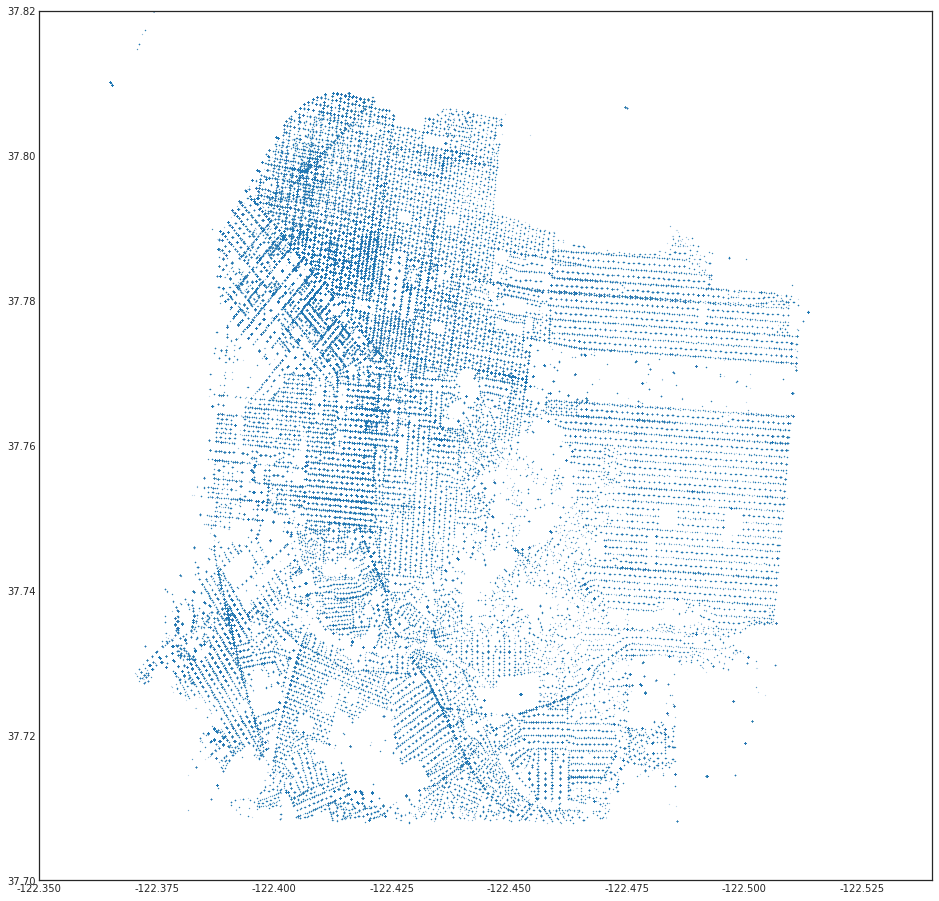

In [7]:
# plot the location of the compliants 
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,16))
plt.ylim(37.70, 37.82)
plt.xlim(-122.350,-122.540)
ax.scatter(train['X'],train['Y'], s=0.01, alpha=1)

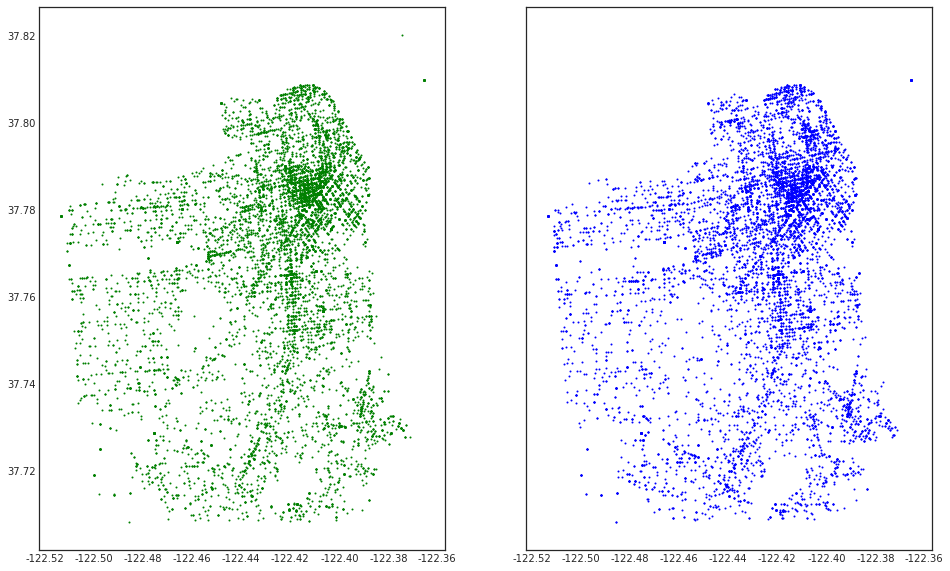

In [8]:
# check overlap between train and test data
N = 10000
city_lat = (37.5, 38)
city_long = (-122.3,-122.7)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16,10))
ax[0].scatter(train.X.values[:N],train.Y.values[:N], color='g', label='train', s=1, alpha=1)
ax[1].scatter(test.X.values[:N],test.Y.values[:N], color='b', label='test', s=1, alpha=1)
plt.show()

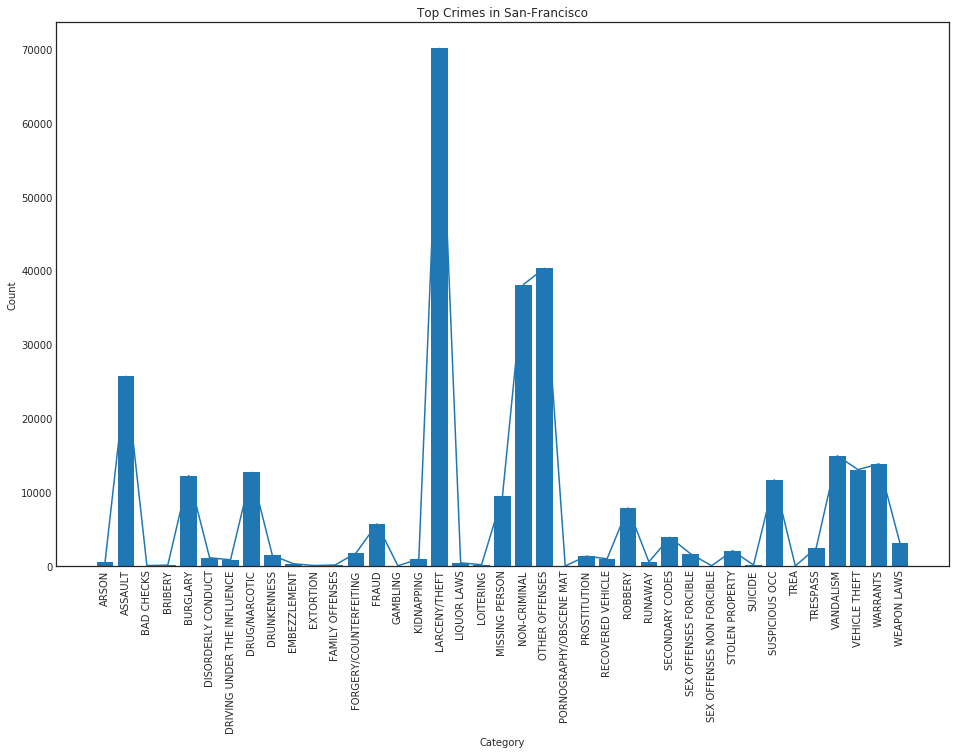

In [13]:
# Plot the Top charges
from collections import Counter

cnt = Counter(train.Category)
xlabels = []
counts = []
for i  in range(len(cnt.most_common())):
    xlabels.append(cnt.most_common()[i][0])
    counts.append(cnt.most_common()[i][1])

plt.plot(train.groupby('Category').count()[['PdDistrict']],'-', label='train')
plt.bar(xlabels, counts)
plt.title('Top Crimes in San-Francisco')
plt.ylabel('Count')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.show()

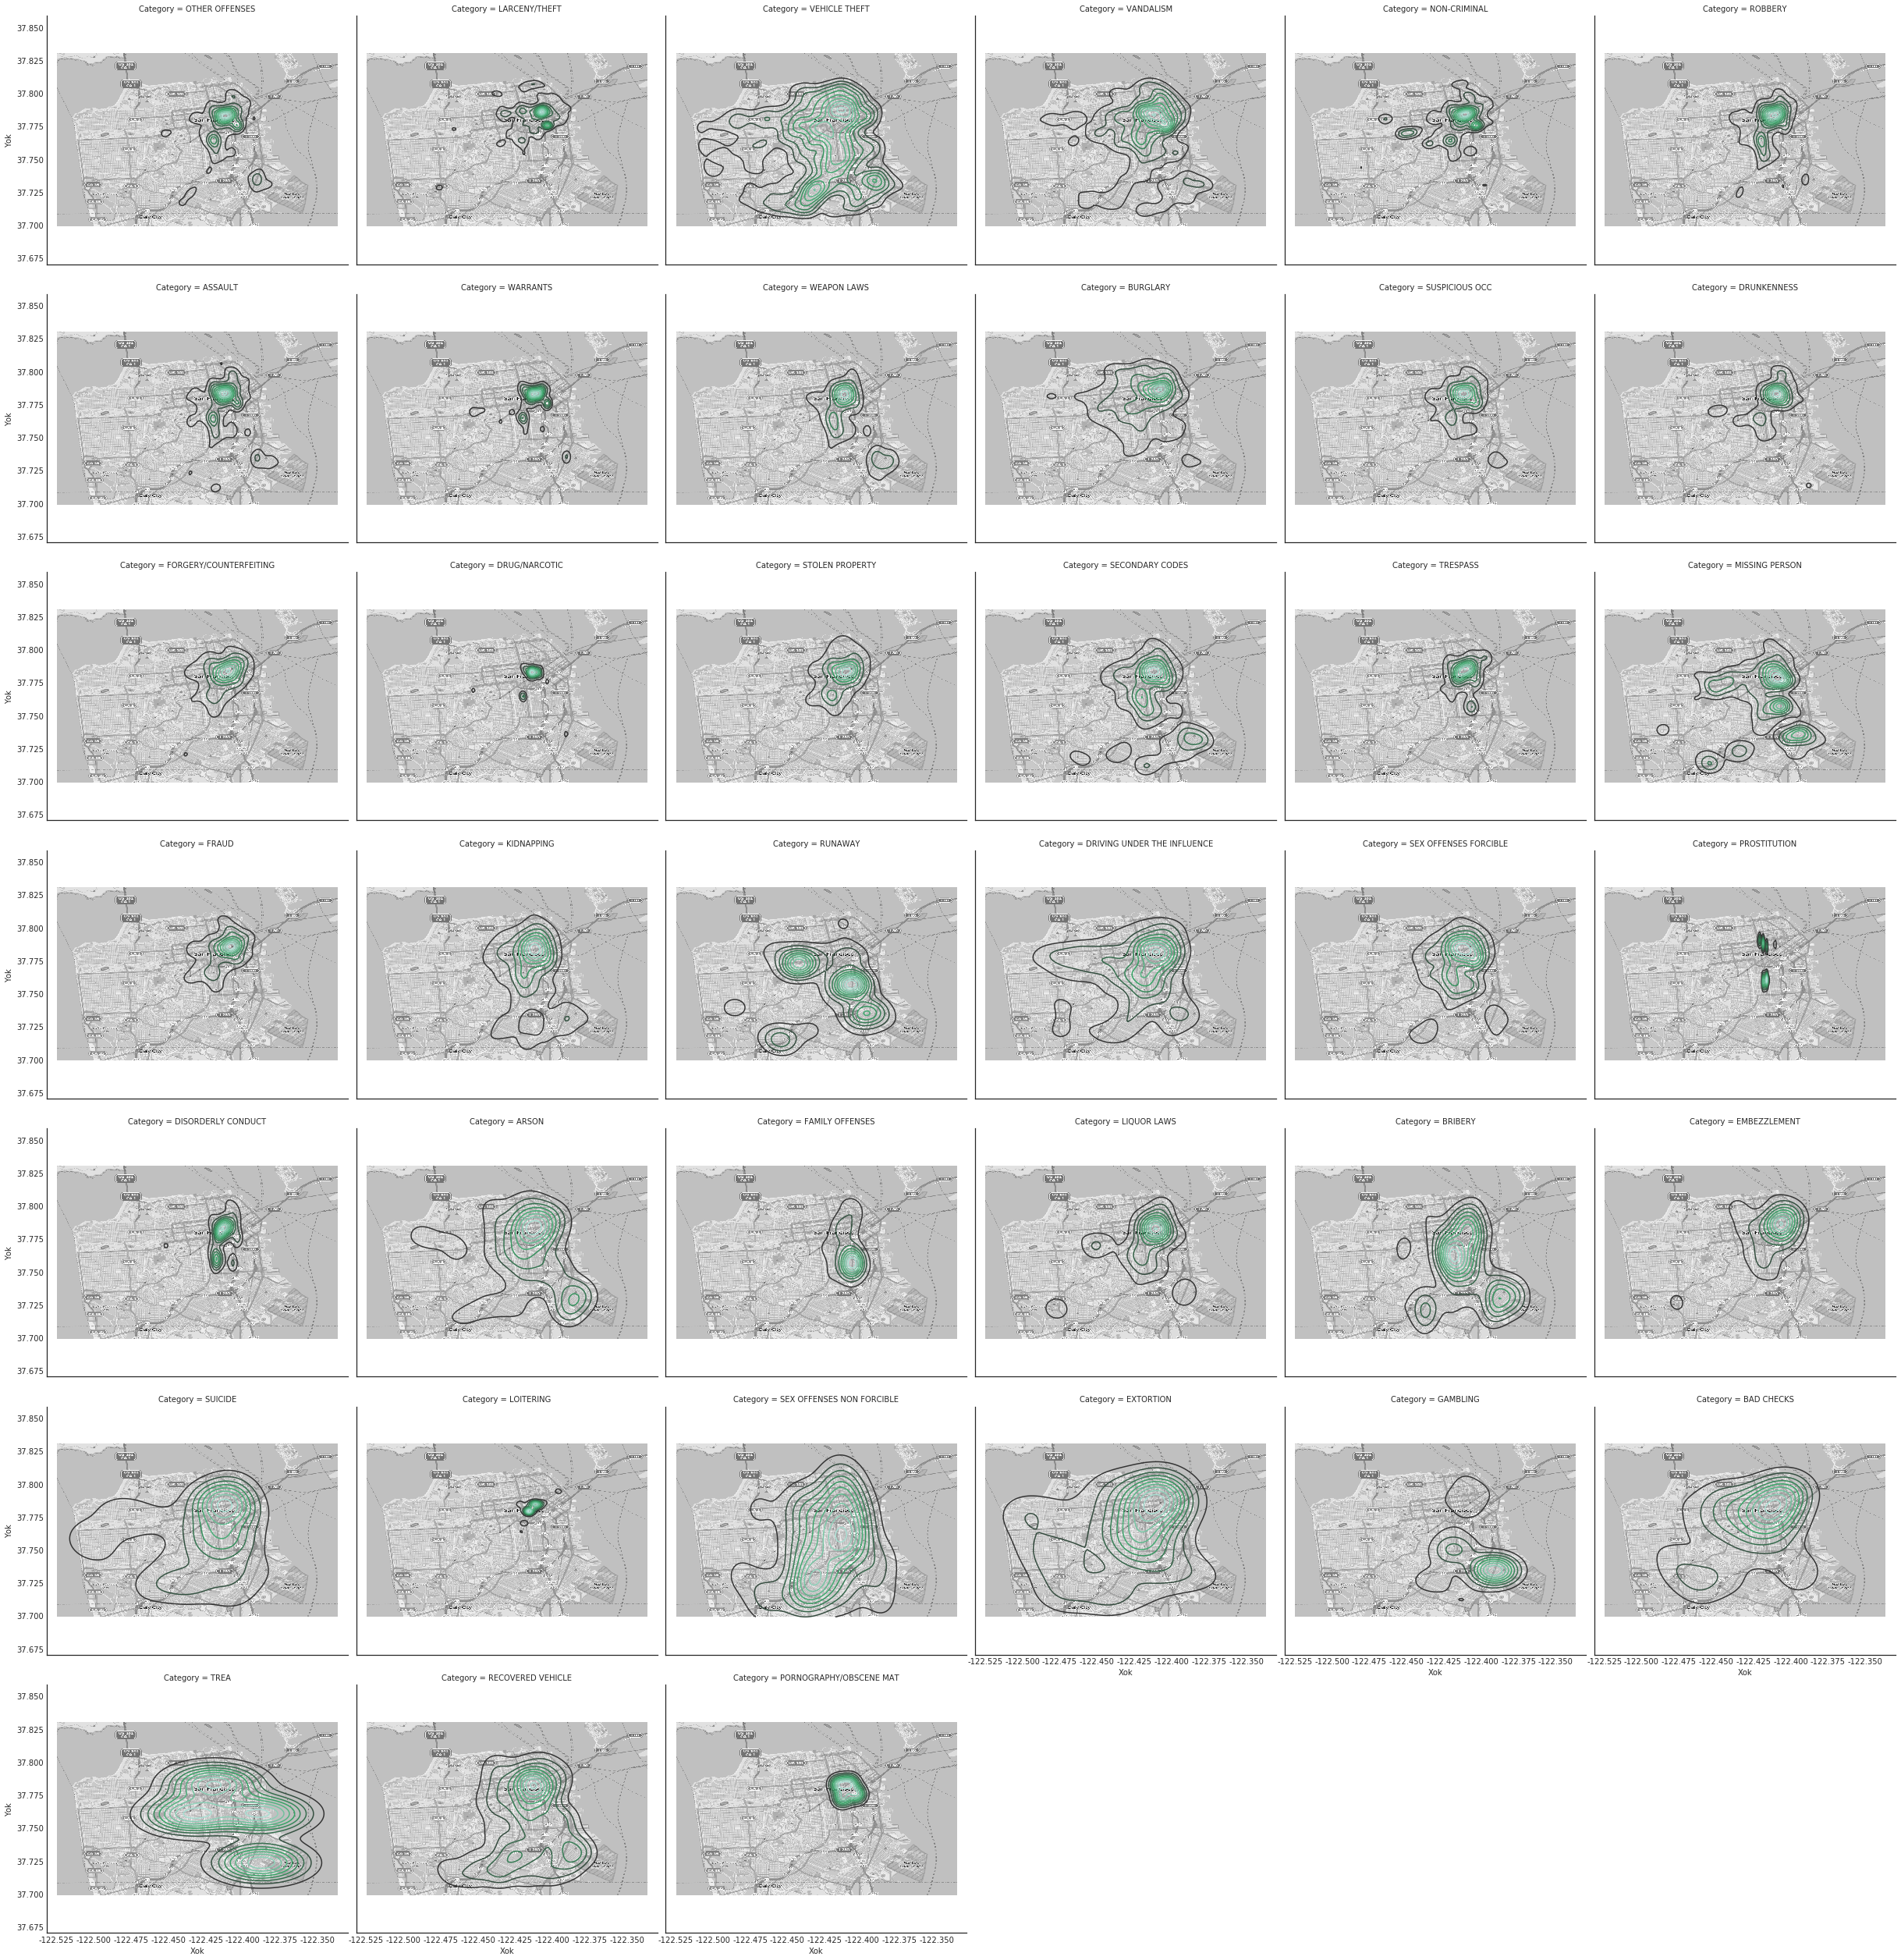

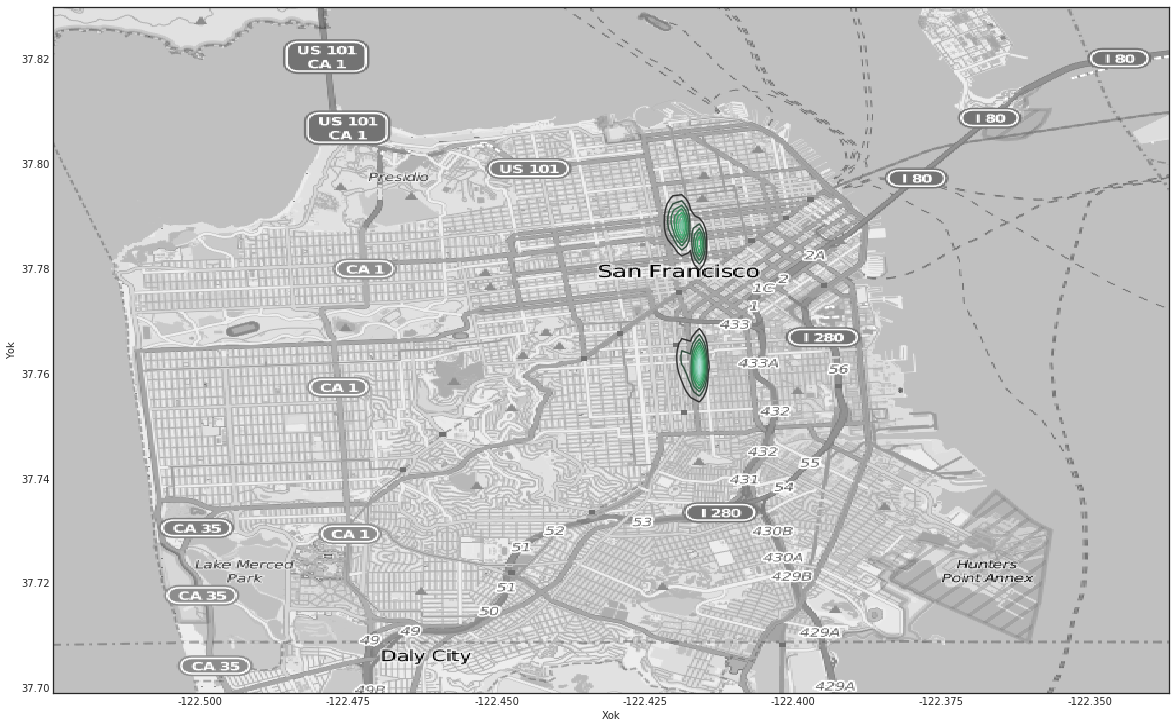

In [10]:
# Supplied map bounding box:
#    ll.lon     ll.lat   ur.lon     ur.lat
#    -122.52469 37.69862 -122.33663 37.82986
mapdata = np.loadtxt("data/sf_map_copyright_openstreetmap_contributors.txt")
asp = mapdata.shape[0] * 1.0 / mapdata.shape[1]

lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)
clipsize = [[-122.5247, -122.3366],[ 37.699, 37.8299]]

#Get rid of the bad lat/longs
train['Xok'] = train[train.X<-121].X
train['Yok'] = train[train.Y<40].Y
train = train.dropna()
trainP = train[train.Category == 'PROSTITUTION'] #Grab the prostitution crimes
train = train[1:300000] #Can't use all the data and complete within 600 sec :(

#Seaborn FacetGrid, split by crime Category
g= sns.FacetGrid(train, col="Category", col_wrap=6, size=5, aspect=1/asp)

#Show the background map
for ax in g.axes:
    ax.imshow(mapdata, cmap=plt.get_cmap('gray'), 
              extent=lon_lat_box, 
              aspect=asp)
#Kernel Density Estimate plot
g.map(sns.kdeplot, "Xok", "Yok", clip=clipsize)

plt.savefig('category_density_plot.png')

#Do a larger plot with prostitution only
plt.figure(figsize=(20,20*asp))
ax = sns.kdeplot(trainP.Xok, trainP.Yok, clip=clipsize, aspect=1/asp)
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), 
              extent=lon_lat_box, 
              aspect=asp)
plt.savefig('prostitution_density_plot.png')

# Using PySpark

In [1]:
from pyspark.sql import SQLContext
from pyspark import SparkContext
sc = SparkContext()
sqlContext = SQLContext(sc)

data = sqlContext.read.format('com.databricks.spark.csv').\
                       options(header='true', inferschema='true').\
                       load('data/train.csv')

In [2]:
drop_list = ['Dates','DayOfWeek','PdDistrict','Resolution','Address','X','Y']
data = data.select([col for col in data.columns if col not in drop_list])
data.show(5)

+--------------+--------------------+
|      Category|            Descript|
+--------------+--------------------+
|      WARRANTS|      WARRANT ARREST|
|OTHER OFFENSES|TRAFFIC VIOLATION...|
|OTHER OFFENSES|TRAFFIC VIOLATION...|
| LARCENY/THEFT|GRAND THEFT FROM ...|
| LARCENY/THEFT|GRAND THEFT FROM ...|
+--------------+--------------------+
only showing top 5 rows



In [3]:
data.printSchema()

root
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)



In [4]:
from pyspark.sql.functions import col

# Top 20 Crimes
data.groupBy("Category")\
    .count()\
    .orderBy(col("count").desc())\
    .show()

+--------------------+------+
|            Category| count|
+--------------------+------+
|       LARCENY/THEFT|174900|
|      OTHER OFFENSES|126182|
|        NON-CRIMINAL| 92304|
|             ASSAULT| 76876|
|       DRUG/NARCOTIC| 53971|
|       VEHICLE THEFT| 53781|
|           VANDALISM| 44725|
|            WARRANTS| 42214|
|            BURGLARY| 36755|
|      SUSPICIOUS OCC| 31414|
|      MISSING PERSON| 25989|
|             ROBBERY| 23000|
|               FRAUD| 16679|
|FORGERY/COUNTERFE...| 10609|
|     SECONDARY CODES|  9985|
|         WEAPON LAWS|  8555|
|        PROSTITUTION|  7484|
|            TRESPASS|  7326|
|     STOLEN PROPERTY|  4540|
|SEX OFFENSES FORC...|  4388|
+--------------------+------+
only showing top 20 rows



In [5]:
# Top 20 crime descriptions
data.groupBy("Descript")\
    .count()\
    .orderBy(col("count").desc())\
    .show()

+--------------------+-----+
|            Descript|count|
+--------------------+-----+
|GRAND THEFT FROM ...|60022|
|       LOST PROPERTY|31729|
|             BATTERY|27441|
|   STOLEN AUTOMOBILE|26897|
|DRIVERS LICENSE, ...|26839|
|      WARRANT ARREST|23754|
|SUSPICIOUS OCCURR...|21891|
|AIDED CASE, MENTA...|21497|
|PETTY THEFT FROM ...|19771|
|MALICIOUS MISCHIE...|17789|
|   TRAFFIC VIOLATION|16471|
|PETTY THEFT OF PR...|16196|
|MALICIOUS MISCHIE...|15957|
|THREATS AGAINST LIFE|14716|
|      FOUND PROPERTY|12146|
|ENROUTE TO OUTSID...|11470|
|GRAND THEFT OF PR...|11010|
|POSSESSION OF NAR...|10050|
|PETTY THEFT FROM ...|10029|
|PETTY THEFT SHOPL...| 9571|
+--------------------+-----+
only showing top 20 rows



In [6]:
#Modeling
# 1. Tokenization(using regex)
# 2. Remove stop words
# 3. Count Vectors
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover,\
                                CountVectorizer
from pyspark.ml.classification import LogisticRegression

# regex tokenizer
reg = RegexTokenizer(inputCol="Descript", outputCol="words", pattern="\\W")

# remove stopwords
sw_list = ["http","https","amp","rt","t","c","the"] 
sw = StopWordsRemover(inputCol="words", outputCol="filtered").\
                                                        setStopWords(sw_list)

# BoW count
count_vecs = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=100000, minDF=2)

In [7]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer,\
                                VectorAssembler

# encodes a string column of labels to a column of label indices. The indices are in [0, numLabels)
label_stringIndex = StringIndexer(inputCol="Category",
                                  outputCol="label")

pipeline = Pipeline(stages=[reg, sw, count_vecs, label_stringIndex])

# fit the pipeline to features
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
dataset.show(5)

+--------------+--------------------+--------------------+--------------------+--------------------+-----+
|      Category|            Descript|               words|            filtered|            features|label|
+--------------+--------------------+--------------------+--------------------+--------------------+-----+
|      WARRANTS|      WARRANT ARREST|   [warrant, arrest]|   [warrant, arrest]|(896,[17,32],[1.0...|  7.0|
|OTHER OFFENSES|TRAFFIC VIOLATION...|[traffic, violati...|[traffic, violati...|(896,[11,17,35],[...|  1.0|
|OTHER OFFENSES|TRAFFIC VIOLATION...|[traffic, violati...|[traffic, violati...|(896,[11,17,35],[...|  1.0|
| LARCENY/THEFT|GRAND THEFT FROM ...|[grand, theft, fr...|[grand, theft, fr...|(896,[0,2,3,4,6],...|  0.0|
| LARCENY/THEFT|GRAND THEFT FROM ...|[grand, theft, fr...|[grand, theft, fr...|(896,[0,2,3,4,6],...|  0.0|
+--------------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [8]:
"""pyspark 2.3.1
   openjdk 10.0.1 2018-04-17
   python 3.6.5
"""
#set seed for reproduciabiility
(trainingData, validationData) = dataset.randomSplit([0.7,0.3], seed=100)
print("Training Dataset Count:".format(str(trainingData.count())))
print("Test Dataset Count:".format(str(validationData.count())))

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(validationData)
predictions.filter(predictions['prediction'] == 0) \
    .select("Descript","Category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)
    
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

Training Dataset Count:
Test Dataset Count:
+------------------------------+-------------+------------------------------+-----+----------+
|                      Descript|     Category|                   probability|label|prediction|
+------------------------------+-------------+------------------------------+-----+----------+
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8727492406494172,0.02031...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8727492406494172,0.02031...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8727492406494172,0.02031...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8727492406494172,0.02031...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8727492406494172,0.02031...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8727492406494172,0.02031...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8727492406494172,0.02031...|  0.0|       0.0|
|THEFT

0.9722078700050668

## Logistic Regression using Tf-IDF Features

In [10]:
from pyspark.ml.feature import HashingTF, IDF

hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)#minDocFreq: remove sparse terms
pipeline = Pipeline(stages=[reg, sw, hashingTF, idf, label_stringIndex])

pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)

(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)
predictions.filter(predictions['prediction'] == 0)\
           .select("Descript","Category","probability","label","prediction")\
           .orderBy("probability", ascending=False)\
           .show(n=10, truncate=30)

+------------------------------+-------------+------------------------------+-----+----------+
|                      Descript|     Category|                   probability|label|prediction|
+------------------------------+-------------+------------------------------+-----+----------+
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8744258244000124,0.01995...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8744258244000124,0.01995...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8744258244000124,0.01995...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8744258244000124,0.01995...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8744258244000124,0.01995...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8744258244000124,0.01995...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8744258244000124,0.01995...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8

In [11]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.9722666656693439

### Cross Validation

In [24]:
pipeline = Pipeline(stages=[reg, sw, hashingTF, idf, label_stringIndex])

pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)

(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

# create ParamGrid for hyperparameter tunning for Logistic regression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
#            .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
#            .addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)
cvModel = cv.fit(trainingData)

predictions = cvModel.transform(testData)
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)


0.9916516196629394

### Naive Bayes

In [15]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(smoothing=1)
model = nb.fit(trainingData)

predictions = model.transform(testData)
predictions.filter(predictions['prediction'] == 0)\
           .select("Descript","Category", "probability", "label", "prediction")\
           .orderBy("probability", ascending=False)\
           .show(n=10, truncate=30)

+-------------------+-------------+------------------------------+-----+----------+
|           Descript|     Category|                   probability|label|prediction|
+-------------------+-------------+------------------------------+-----+----------+
|GRAND THEFT BICYCLE|LARCENY/THEFT|[1.0,1.9707929663922744E-29...|  0.0|       0.0|
|GRAND THEFT BICYCLE|LARCENY/THEFT|[1.0,1.9707929663922744E-29...|  0.0|       0.0|
|GRAND THEFT BICYCLE|LARCENY/THEFT|[1.0,1.9707929663922744E-29...|  0.0|       0.0|
|GRAND THEFT BICYCLE|LARCENY/THEFT|[1.0,1.9707929663922744E-29...|  0.0|       0.0|
|GRAND THEFT BICYCLE|LARCENY/THEFT|[1.0,1.9707929663922744E-29...|  0.0|       0.0|
|GRAND THEFT BICYCLE|LARCENY/THEFT|[1.0,1.9707929663922744E-29...|  0.0|       0.0|
|GRAND THEFT BICYCLE|LARCENY/THEFT|[1.0,1.9707929663922744E-29...|  0.0|       0.0|
|GRAND THEFT BICYCLE|LARCENY/THEFT|[1.0,1.9707929663922744E-29...|  0.0|       0.0|
|GRAND THEFT BICYCLE|LARCENY/THEFT|[1.0,1.9707929663922744E-29...|  0.0|    

In [19]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.9954359270376009

### Random Forest

In [20]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, maxDepth=4, maxBins=32)
model = rf.fit(trainingData)
predictions = model.transform(testData)
predictions.filter(predictions['prediction'] == 0)\
           .select("Descript","Category", "probability", "label", "prediction")\
           .orderBy("probability", ascending=False)\
           .show(n=10, truncate=30)

+----------------------------+-------------+------------------------------+-----+----------+
|                    Descript|     Category|                   probability|label|prediction|
+----------------------------+-------------+------------------------------+-----+----------+
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.3450477182612741,0.11639...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.3450477182612741,0.11639...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.3450477182612741,0.11639...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.3450477182612741,0.11639...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.3450477182612741,0.11639...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.3450477182612741,0.11639...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.3450477182612741,0.11639...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.3450477182612741,0.1163

In [21]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.3752115856234946